In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
% matplotlib inline
plt.style.reload_library()
plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
import numpy as np
import math
from core.synapse import DoubleExponentialSynapse, Synapse
from core.population import Population, SecondOrderPopulation
from core.utility import nmrse

Find Optimal Parameters for DoubleExponentialSynapse to Represent Jansen-Rit Second Order Synapse
---------------------------------------------------------------------------------------------------------------

**1. Set parameters for synapses** 

In [88]:
######################
# synapse parameters #
######################

# general synapse parameters
bin_size = 5e-4

# second-order synapse parameters (inhibitory synapse)
def exponential(t, tau):
    return t * np.exp(-t / tau) / tau
synapse_params2 = {'efficacy': 3.25 * 1e-3,
                   'kernel_function': exponential,
                   'tau': 0.01,
                   'epsilon': 5e-5}

# first-order synapse parameters (GABAA synapse)
synapse_params1_tmp = {'tau_rise': 0.0006,
                       'tau_decay': 0.006,
                       'efficacy': 1.273 * 3e-13,
                       'epsilon': 5e-15}

tau_rise = np.arange(0.0001, 0.0009, 0.0001)
tau_decay = np.arange(0.001, 0.009, 0.001)
efficacy = np.arange(0.5, 1.5, 0.1) * 1.273 * 3e-13
synapse_params1 = list()
for tr in tau_rise:
    for td in tau_decay:
        for e in efficacy:
            synapse_params1_tmp2 = synapse_params1_tmp.copy()
            synapse_params1_tmp2['tau_rise'] = tr
            synapse_params1_tmp2['tau_decay'] = td
            synapse_params1_tmp2['efficacy'] = e
            synapse_params1.append(synapse_params1_tmp2)

n_conditions = len(synapse_params1)
print('Number of total conditions: ', n_conditions)

Number of total conditions:  640


**2. Create Populations with single synapse each and look at their behavior for gaussian input**

In [89]:
# initialize stuff
n_steps = 300
n_input_steps = 100
synaptic_input = np.zeros((n_steps, 1, 1))
synaptic_input[0:n_input_steps, :, :] = 20 * np.random.randn(n_input_steps, 1, 1) + 200
first_order_states = np.zeros((n_steps+1, n_conditions))
synapses = list()

#########################################################
# create and update population with first order synapse #
#########################################################

for n in range(n_conditions):
    
    # instantiate population
    first_order_population = Population(synapse_params=[synapse_params1[n]], axon='JansenRitAxon', step_size=bin_size,
                                       store_state_variables=True, init_state=-0.075)

    for i in range(n_steps):

        # update population
        first_order_population.state_update(synaptic_input[i])
        
    # collect states
    first_order_states[:, n] = np.array(first_order_population.state_variables).squeeze()
    
    # collect synapse
    synapses.append(first_order_population.synapses[0])

##########################################################
# create and update population with second order synapse #
##########################################################

# instantiate population
second_order_population = SecondOrderPopulation(synapse_params=[synapse_params2], axon='JansenRitAxon', step_size=bin_size,
                                                synapse_class='Synapse', store_state_variables=True, init_state=0.0)

for i in range(n_steps):

        # update population
        second_order_population.state_update(synaptic_input[i])
        
# collect states
second_order_states = np.array(second_order_population.state_variables) - 0.075

**3. Plot kernels and population states**

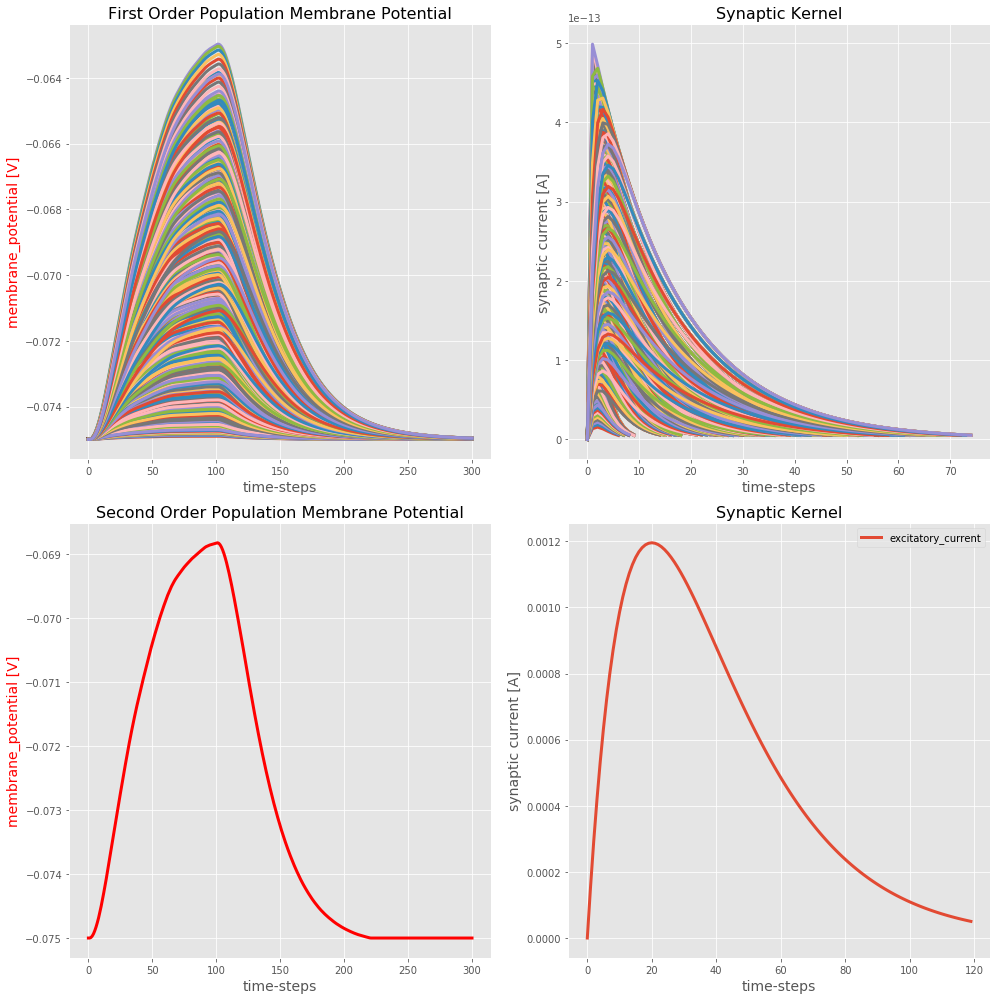

In [90]:
#########################################################
# plot synaptic kernels and population states over time #
#########################################################

fig, axes = plt.subplots(2,2, figsize=(14,14))

# first order states
ax1 = axes[0, 0]
for n in range(n_conditions):
    ax1.plot(first_order_states[:, n].squeeze())
ax1.set_title('First Order Population Membrane Potential')
ax1.set_xlabel('time-steps')
ax1.set_ylabel('membrane_potential [V]', color='r')

# first order kernels
ax2 = axes[0, 1]
for n in range(n_conditions):
    ax2 = synapses[n].plot_synaptic_kernel(create_plot=False, axes=ax2)

# second order states
ax3 = axes[1, 0]
ax3.plot(second_order_states, 'r')
ax3.set_title('Second Order Population Membrane Potential')
ax3.set_xlabel('time-steps')
ax3.set_ylabel('membrane_potential [V]', color='r')

# first order kernel
ax4 = axes[1, 1]
ax4 = second_order_population.plot_synaptic_kernels(create_plot=False, axes=ax4)

plt.tight_layout()

**4. Calculate Error between population states for each condition and find best parametrization**

Optimal synapse parameters:  {'tau_rise': 0.00040000000000000002, 'epsilon': 5e-15, 'efficacy': 4.5827999999999984e-13, 'tau_decay': 0.0050000000000000001}
Min NMRSE:  0.349563627651


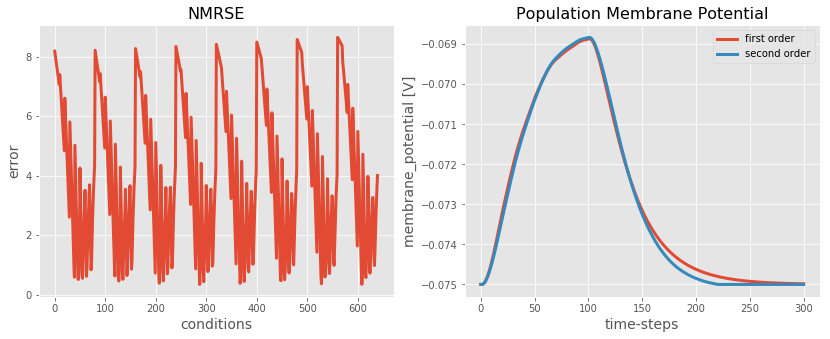

In [91]:
###############################################
# calculate the error between the time-series #
###############################################

errors = np.zeros(n_conditions)
for n in range(n_conditions):
    errors[n] = nmrse(first_order_states[:, n].squeeze(), second_order_states.squeeze())

##############
# plot error #
##############

fig, axes = plt.subplots(1, 2, figsize=(14,5))

ax1 = axes[0]
ax1.plot(errors)
ax1.set_ylabel('error')
ax1.set_xlabel('conditions')
ax1.set_title('NMRSE')

###########################################
# show parameters of best fitting synapse #
###########################################

idx = np.argmin(errors)
synapse_params = synapse_params1[idx]
print('Optimal synapse parameters: ', synapse_params)
print('Min NMRSE: ', errors[idx])

#####################################################
# plot best fitting states with second order states #
#####################################################

ax2 = axes[1]
ax2.plot(first_order_states[:, idx].squeeze())
ax2.plot(second_order_states)
ax2.set_title('Population Membrane Potential')
ax2.set_xlabel('time-steps')
ax2.set_ylabel('membrane_potential [V]')
ax2.legend(['first order', 'second order'])